In [4]:
import asf_search as asf
import geopandas as gpd
from shapely.geometry import box
from shapely.ops import unary_union
from shapely import force_2d
from rasterio.crs import CRS
import pandas as pd
import yaml
from pathlib import Path
from tqdm import tqdm
import rasterio
import numpy as np
from asf_search import ASFSession
import http.cookiejar
from dem_stitcher.geojson_io import read_geojson_gzip
import backoff
from skimage.restoration import denoise_tv_bregman
import matplotlib.pyplot as plt
from dem_stitcher.rio_tools import reproject_arr_to_match_profile

In [5]:
DAAC_ENV_CONFIG = {'GDAL_HTTP_UNSAFESSL': 'YES',
                   'GDAL_HTTP_COOKIEFILE': '~/cookies.txt',
                   'GDAL_HTTP_COOKIEJAR': '~/cookies.txt',
                   'GDAL_DISABLE_READDIR_ON_OPEN': 'YES',
                   'CPL_VSIL_CURL_ALLOWED_EXTENSIONS': 'TIF'}

# Parameters

In [6]:
EVENT_NAME = 'chile_fire_2024'

# Read Yaml

In [7]:
yaml_file = f'events/{EVENT_NAME}.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'chile_fire_2024',
 'bounds': [-71.53071089, -33.20143816, -71.2964628, -32.98270579],
 'event_date': '2024-02-04',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [18, 156],
 'mgrs_tiles': ['19HBD'],
 'source_id': 'EMSR715',
 'dist_hls_confirmed_change_min_days': 30,
 'links': ['https://earthobservatory.nasa.gov/images/152411/fires-rage-in-central-chile',
  'https://en.wikipedia.org/wiki/2024_Chile_wildfires']}

In [4]:
aoi = box(*event_dict['bounds'])
df_aoi = gpd.GeoDataFrame(geometry=[aoi], crs=CRS.from_epsg(4326))

In [12]:
df_mgrs = gpd.read_file('https://raw.githubusercontent.com/NASA-IMPACT/hls-land_tiles/master/s2_grid.json')
df_mgrs_overlapping = df_mgrs[df_mgrs.identifier.isin(event_dict['mgrs_tiles'])].reset_index(drop=True)
df_mgrs_overlapping.rename(columns={'identifier': 'tile_id'}, inplace=True)
# Remove extra column
df_mgrs_overlapping.drop(columns='type', inplace=True)
df_mgrs_overlapping['geometry'] = df_mgrs_overlapping.geometry.map(lambda multi_geo: unary_union(multi_geo.geoms))
# Makes 3d or Z dimension go away
df_mgrs_overlapping['geometry'] = df_mgrs_overlapping.geometry.map(lambda geo: force_2d(geo))
df_mgrs_overlapping.head()

,tile_id,geometry
0,19HBD,"POLYGON ((-72.19295 -32.49681, -71.02522 -32.5..."


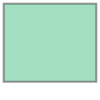

In [13]:
df_mgrs_search = df_mgrs_overlapping[df_mgrs_overlapping.tile_id.isin(event_dict['mgrs_tiles'])].reset_index(drop=True)
search_geo = box(*df_mgrs_search.total_bounds)
search_geo

# Assign dates from event dict

In [14]:
import datetime
EVENT_DT = datetime.datetime.strptime(event_dict['event_date'], "%Y-%m-%d")
PRE_DT_START = EVENT_DT - datetime.timedelta(days=event_dict['pre_event_window_days'])
POST_DT_STOP = EVENT_DT + datetime.timedelta(days=event_dict['post_event_window_days'])


In [15]:
resp = asf.geo_search(intersectsWith=search_geo.wkt,
                                 processingLevel='RTC',
                                 platform=asf.constants.SENTINEL1, 
                                 start=PRE_DT_START, 
                                 end=POST_DT_STOP,
                                 relativeOrbit=event_dict['rtc_track_numbers']
                                )

In [16]:
df_rtc_resp = gpd.GeoDataFrame.from_features(resp.geojson(), crs=CRS.from_epsg(4326))
df_rtc_resp['acq_dt'] = pd.to_datetime(df_rtc_resp.startTime)
df_rtc_resp['acq_date'] = pd.to_datetime(df_rtc_resp.startTime).dt.round('D').dt.date

In [17]:
sorted(df_rtc_resp.acq_date.unique())

[datetime.date(2023, 11, 1),
 datetime.date(2023, 11, 10),
 datetime.date(2023, 11, 13),
 datetime.date(2023, 11, 22),
 datetime.date(2023, 11, 25),
 datetime.date(2023, 12, 4),
 datetime.date(2023, 12, 7),
 datetime.date(2023, 12, 16),
 datetime.date(2023, 12, 19),
 datetime.date(2023, 12, 28),
 datetime.date(2023, 12, 31),
 datetime.date(2024, 1, 9),
 datetime.date(2024, 1, 12),
 datetime.date(2024, 1, 21),
 datetime.date(2024, 1, 24),
 datetime.date(2024, 2, 2),
 datetime.date(2024, 2, 5),
 datetime.date(2024, 2, 14),
 datetime.date(2024, 2, 17),
 datetime.date(2024, 2, 26),
 datetime.date(2024, 2, 29),
 datetime.date(2024, 3, 9),
 datetime.date(2024, 3, 12),
 datetime.date(2024, 3, 21),
 datetime.date(2024, 3, 24),
 datetime.date(2024, 4, 2)]

<Axes: >

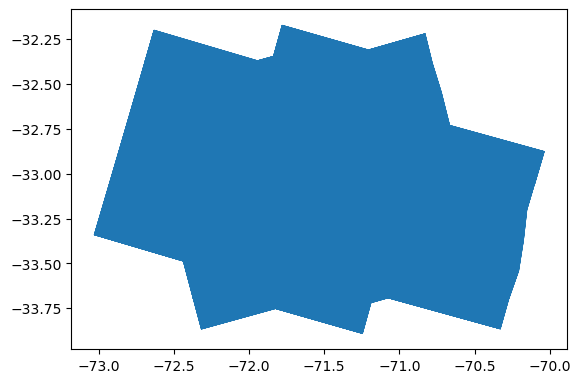

In [18]:
df_rtc_resp.plot()

# Save Data

In [19]:
burst_dir = Path('out') / event_dict['event_name'] / 'burst_data' 
burst_dir.mkdir(exist_ok=True, parents=True)
burst_dir

PosixPath('out/chile_fire_2024/burst_data')

In [39]:
from requests.exceptions import HTTPError
from mpire import WorkerPool
import scipy.ndimage as ndimage
from skimage.measure import regionprops, label

def despeckle_one(
    X: np.ndarray, reg_param=5, noise_floor_db=-22, preserve_nans=True
) -> np.ndarray:
    X_c = np.clip(X, 1e-7, 1)
    X_db = 10 * np.log10(X_c, out=np.full(X_c.shape, np.nan), where=(~np.isnan(X_c)))
    X_db[np.isnan(X_c)] = noise_floor_db
    X_db_dspkl = denoise_tv_bregman(
        X_db, weight=1.0 / reg_param, isotropic=True, eps=1e-3
    )
    X_dspkl = np.power(10, X_db_dspkl / 10.0)

    data_mask = np.isnan(X_c).astype(bool)
    mask_labels = label(data_mask)
    
    exterior_mask_val = mask_labels[0, 0]
    assert all([exterior_mask_val == mask_labels[i, j] for i in [0, -1] for j in [0, -1]])
    exterior_mask = (mask_labels == exterior_mask_val).astype(np.uint8)

    exterior_mask_b = ndimage.binary_dilation(exterior_mask, iterations=4).astype(bool)
    
    if preserve_nans:
        X_dspkl[exterior_mask_b] = np.nan
    else:
         X_dspkl[exterior_mask_b] = 0
    X_dspkl = np.clip(X_dspkl, 0, 1)
    
    return X_dspkl


def localize_one_rtc(
    url: str | Path | list | tuple,
    ts_dir: str | Path = Path("."),
) -> Path:
    if isinstance(url, (list, tuple)):
        local_fn = url[0].split("/")[-1]
        local_fn = f"{local_fn[:-7]}_stack.tif"
    else:
        local_fn = url.split("/")[-1]

    out_path = ts_dir / local_fn

    if out_path.exists():
        return out_path

    def open_one(url: str) -> tuple:
        with rasterio.Env(**DAAC_ENV_CONFIG):
            with rasterio.open(url) as ds:
                X = ds.read(1)
                p = ds.profile

        X = np.clip(X, 1e-7, 1)
        return X, p

    if not isinstance(url, (list, tuple)):
        arrs, ps = zip(*[open_one(url)])
    else:
        arrs, ps = zip(*list(map(open_one, url)))


    X_out = np.stack(arrs, axis=0)
    p = ps[0].copy()
    p["count"] = X_out.shape[0]
    with rasterio.open(out_path, "w", **p) as ds:
        ds.write(X_out)
    return X_out

In [40]:
%%time


for (track_number, date), df_rtc_date in tqdm(df_rtc_resp.groupby(['pathNumber', 'acq_date']), desc='dates'):
    print(track_number, date, df_rtc_date.shape[0])
    vh_urls = df_rtc_date.url.tolist()
    vv_urls = [url.replace('VH.tif', 'VV.tif') for url in vh_urls]
    ts_dir = burst_dir / f'track{str(track_number)}' / f'{str(date)}'
    ts_dir.mkdir(exist_ok=True, parents=True)
    localize_one_rtc_p = lambda url: localize_one_rtc(url, ts_dir=ts_dir)

    with WorkerPool(n_jobs=5, use_dill=True) as pool:
        dual_loc_path = pool.map(
            localize_one_rtc_p,
            vv_urls + vh_urls,
            progress_bar=True,\
            progress_bar_style="std",
            concatenate_numpy_output=False,
        )


dates:   0%|                 | 0/26 [00:00<?, ?it/s]

18 2023-11-01 16


dates:   4%|▎        | 1/26 [00:00<00:07,  3.16it/s]

18 2023-11-13 16


dates:   8%|▋        | 2/26 [00:00<00:06,  3.65it/s]

18 2023-11-25 16


dates:  12%|█        | 3/26 [00:00<00:06,  3.75it/s]

18 2023-12-07 16


dates:  15%|█▍       | 4/26 [00:01<00:05,  3.77it/s]

18 2023-12-19 16


dates:  19%|█▋       | 5/26 [00:01<00:05,  3.78it/s]

18 2023-12-31 16


dates:  23%|██       | 6/26 [00:01<00:05,  3.78it/s]

18 2024-01-12 16


dates:  27%|██▍      | 7/26 [00:01<00:05,  3.79it/s]

18 2024-01-24 16


dates:  31%|██▊      | 8/26 [00:02<00:04,  3.80it/s]

18 2024-02-05 16


dates:  35%|███      | 9/26 [00:02<00:05,  2.84it/s]

18 2024-02-17 16


dates:  38%|███     | 10/26 [00:02<00:05,  3.13it/s]

18 2024-02-29 32


dates:  42%|███▍    | 11/26 [00:03<00:04,  3.34it/s]

18 2024-03-12 29


dates:  46%|███▋    | 12/26 [00:03<00:04,  3.48it/s]

18 2024-03-24 16


dates:  50%|████    | 13/26 [00:03<00:03,  3.61it/s]

156 2023-11-10 22


dates:  54%|████▎   | 14/26 [00:03<00:03,  3.71it/s]

156 2023-11-22 22


dates:  58%|████▌   | 15/26 [00:04<00:02,  3.70it/s]

156 2023-12-04 44


dates:  62%|████▉   | 16/26 [00:04<00:02,  3.73it/s]

156 2023-12-16 44


dates:  65%|█████▏  | 17/26 [00:04<00:02,  3.75it/s]

156 2023-12-28 22


dates:  69%|█████▌  | 18/26 [00:04<00:02,  3.82it/s]

156 2024-01-09 22


dates:  73%|█████▊  | 19/26 [00:05<00:01,  3.84it/s]

156 2024-01-21 22


dates:  77%|██████▏ | 20/26 [00:05<00:01,  3.84it/s]

156 2024-02-02 22


dates:  81%|██████▍ | 21/26 [00:05<00:01,  3.87it/s]

156 2024-02-14 44


dates:  85%|██████▊ | 22/26 [00:06<00:01,  3.92it/s]

156 2024-02-26 13


dates:  88%|███████ | 23/26 [00:06<00:00,  3.87it/s]

156 2024-03-09 27


dates:  92%|███████▍| 24/26 [00:06<00:00,  3.86it/s]

156 2024-03-21 22


dates:  96%|███████▋| 25/26 [00:06<00:00,  3.88it/s]

156 2024-04-02 22


dates: 100%|████████| 26/26 [00:07<00:00,  3.68it/s]

CPU times: user 471 ms, sys: 1.44 s, total: 1.91 s
Wall time: 7.07 s


# Merge data

In [ ]:
change_dir_hls = Path('out') / event_dict['event_name'] / 'change_map_dist_hls'
change_dir_hls.mkdir(exist_ok=True, parents=True)

In [ ]:
change_map_tif = list(change_dir_hls.glob('*.tif'))[0]
with rasterio.open(change_map_tif) as ds:
    ref_profile_dist_hls = ds.profile

In [41]:
track_dirs = [burst_dir / f'track{t}' for t in event_dict["rtc_track_numbers"]]
acq_dirs = sorted([date_dir for track_dir in track_dirs for date_dir in track_dir.glob('*/')])
acq_dirs

[PosixPath('out/chile_fire_2024/burst_data/track156/2023-11-10'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2023-11-22'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2023-12-04'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2023-12-16'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2023-12-28'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2024-01-09'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2024-01-21'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2024-02-02'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2024-02-14'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2024-02-26'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2024-03-09'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2024-03-21'),
 PosixPath('out/chile_fire_2024/burst_data/track156/2024-04-02'),
 PosixPath('out/chile_fire_2024/burst_data/track18/2023-11-01'),
 PosixPath('out/chile_fire_2024/burst_data/track18/2023-11-13'),
 PosixPath('

In [42]:
from rasterio.merge import merge
def merge_one_dir(acq_dir: Path, pol='VV', preserve_nans=True) -> list:
    assert pol in ['VV', 'VH']
    all_img_paths = list(acq_dir.glob(f'OPERA*{pol}.tif'))
    date_str = acq_dir.stem
    track_str = acq_dir.parent.stem
    acq_date_track_token = f'{date_str}_track{track_str}'

    ts_dir = burst_dir.parent / 'rtc_ts_merged' / track_str 
    ts_dir.mkdir(exist_ok=True, parents=True)

    dst_path = ts_dir / f'merged_{acq_date_track_token}_{pol}.tif'

    
    if dst_path.exists():
        return dst_path
        
    X_m, t_m = merge(all_img_paths, dtype='float32', method='first')
    with rasterio.open(all_img_paths[0]) as ds:
        p = ds.profile
    prof_merged = p.copy()
    prof_merged['transform'] = t_m
    prof_merged['count'] = X_m.shape[0]
    prof_merged['height'] = X_m.shape[1]
    prof_merged['width'] = X_m.shape[2]

    X_m_d = despeckle_one(X_m[0, ...], preserve_nans=preserve_nans)

    X_m_d_r, p_m_r = reproject_arr_to_match_profile(X_m_d, prof_merged, ref_profile_dist_hls)
    
    with rasterio.open(dst_path, 'w', **p_m_r) as ds:
        ds.write(X_m_d_r)
    
    return dst_path

In [43]:
dst_paths = [merge_one_dir(directory, pol=pol) for directory in tqdm(acq_dirs[:]) for pol in ['VV', 'VH']]
dst_paths

100%|███████████████| 26/26 [20:32<00:00, 47.41s/it]


[PosixPath('out/chile_fire_2024/rtc_ts_merged/track156/merged_2023-11-10_tracktrack156_VV.tif'),
 PosixPath('out/chile_fire_2024/rtc_ts_merged/track156/merged_2023-11-10_tracktrack156_VH.tif'),
 PosixPath('out/chile_fire_2024/rtc_ts_merged/track156/merged_2023-11-22_tracktrack156_VV.tif'),
 PosixPath('out/chile_fire_2024/rtc_ts_merged/track156/merged_2023-11-22_tracktrack156_VH.tif'),
 PosixPath('out/chile_fire_2024/rtc_ts_merged/track156/merged_2023-12-04_tracktrack156_VV.tif'),
 PosixPath('out/chile_fire_2024/rtc_ts_merged/track156/merged_2023-12-04_tracktrack156_VH.tif'),
 PosixPath('out/chile_fire_2024/rtc_ts_merged/track156/merged_2023-12-16_tracktrack156_VV.tif'),
 PosixPath('out/chile_fire_2024/rtc_ts_merged/track156/merged_2023-12-16_tracktrack156_VH.tif'),
 PosixPath('out/chile_fire_2024/rtc_ts_merged/track156/merged_2023-12-28_tracktrack156_VV.tif'),
 PosixPath('out/chile_fire_2024/rtc_ts_merged/track156/merged_2023-12-28_tracktrack156_VH.tif'),
 PosixPath('out/chile_fire_202

# Remove Source Burst Directory

In [44]:
# import shutil

# shutil.rmtree(burst_dir)